# METADATA
- Notebook implementing Vanilla Normalizing Flows
- Created: 7th June, 2021
- Author: Aditya Ahuja

In [1]:
WANDB_DESC = 'Setting up BNAF.'

# PRELIMINARY

### Need PyTorch 1.9.0+cu102 for BNAF.

In [2]:
%%capture
! pip3 install torch==1.9.0+cu102 torchvision==0.10.0+cu102 -f https://download.pytorch.org/whl/torch_stable.html
! pip install wandb

In [3]:
import torch
assert torch.__version__ == '1.9.0+cu102'
! pip list | grep torch

torch                         1.9.0+cu102        
torchsummary                  1.5.1              
torchtext                     0.10.0             
torchvision                   0.10.0+cu102       


In [5]:
! wandb login

wandb: Currently logged in as: adiah80 (use `wandb login --relogin` to force relogin)


## Preliminary

In [6]:
### COLAB ###

# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

# Install missing packages
! apt-get install tree >/dev/null

# Download dataset
# ! ./get_dataset.sh

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Input format of files in $ROOT/data
INPUT_FORMAT = 'Boosted_Jets_Sample-{}.snappy.parquet'

In [8]:
''' DOING IMPORTS '''

import os
import cv2
import wandb
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
from tqdm.auto import tqdm, trange
import torch.nn.functional as F


# Set Numpy Print Options
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

In [10]:
''' CREATE AND SET DATA/CACHE DIRECTORIES '''

ROOT = '/content/drive/My Drive/_GSoC/Normalizing-Flows/'
DATA_ROOT = ROOT + "data/"
CACHE_ROOT = ROOT + "cache/"
LOGS_ROOT = ROOT + "logs/"

os.chdir(ROOT)
os.makedirs(DATA_ROOT, exist_ok=True)
os.makedirs(CACHE_ROOT, exist_ok=True)
os.makedirs(LOGS_ROOT, exist_ok=True)

# Initialize scratch space on /content for faster read-write
SCRATCH_ROOT = '/content/scratch/'   
os.makedirs(SCRATCH_ROOT, exist_ok=True) 

# print('Directory Structure [Excluding Log/Temp Files]:')
# ! tree -I 'model*|temp__*'

In [11]:
# ''' FUNCTIONS: DATA/INSTANCE LOADING '''

# def load_dataset(dataset_file):
#     f_path = DATA_ROOT + dataset_file
#     data = pq.read_table(f_path)
#     return data
        
# def get_instance(data, idx):
#     assert idx < 32000
#     instance = np.array(data[0][idx].as_py())
#     return instance

In [12]:
# ''' FUNCTIONS: PARSING/VISUALIZING IMAGES '''

# def parse_img(track_img, reduce=False):
#     if reduce:
#         track_img = cv2.resize(track_img, dsize=(25,25))
#         # plt.imshow(track_img)
        
#     x_pos = []
#     y_pos = []
#     val = []
#     for x_idx in range(track_img.shape[0]):
#         for y_idx in range(track_img.shape[1]):
#             if track_img[x_idx][y_idx] != 0:
#                 val.append(track_img[x_idx][y_idx])
#                 x_pos.append(x_idx)
#                 y_pos.append(y_idx)
    
#     if reduce:
#         x_pos = [5*v for v in x_pos]
#         y_pos = [5*v for v in y_pos]
#     # print(len(x_pos), len(y_pos), len(val))
#     return x_pos, y_pos, val

# def vis(img, title=None, scale=1000, cmap='gist_heat', reduce=False):        
#     x_pos, y_pos, val = parse_img(img, reduce)
#     if scale:
#         sz = np.array(np.abs(val))*scale
#     else:
#         sz = np.ones_like(val) * 10
        
#     plt.figure(figsize=[14,6], facecolor='#f0f0f0')
#     cm = plt.cm.get_cmap(cmap)     # 'gist_heat' / 'YlOrRd'
#     sc = plt.scatter(x_pos, y_pos, c=val, s=sz, cmap=cm, alpha=0.5, edgecolors='k')
#     plt.colorbar(sc)
#     plt.xlim(0, 125)
#     plt.ylim(0, 125)
#     plt.grid()
#     if title:
#         plt.title(title)
#     plt.show()

In [13]:
# ''' ANALYSING PARSED IMAGES '''

# if DO_ANALYSIS:
#     dataset_file = INPUT_FORMAT.format(0)
#     data = load_dataset(dataset_file)
    
#     img = get_instance(data, 2)
#     vis(img[0], scale=500, title='Track')
#     vis(img[1], scale=200, title='ECAL')
#     vis(img[2], scale=300, title='HCAL', reduce=True)

# LOAD DATA

TODO: Add notebook to generate Cache from raw parquet files

In [14]:
# ''' LOADING THE SINGLE PARSED DATASET '''

# def load_cached_dataset(file_name):
#     with open(CACHE_ROOT + file_name, 'rb') as f:
#         X_dict = pkl.load(f)
#     X_track = X_dict['X_track']
#     X_ECAL = X_dict['X_ECAL']
#     X_HCAL = X_dict['X_HCAL']
#     return X_track, X_ECAL, X_HCAL

# X_track, X_ECAL, X_HCAL = load_cached_dataset('X_dict.pkl')
# print(len(X_track), len(X_ECAL), len(X_HCAL))

In [15]:
# dataset_file = INPUT_FORMAT.format(0)
# data = load_dataset(dataset_file)    

In [16]:
import torch
from torch.utils.data import *

class ParquetDataset(Dataset):
    def __init__(self, filename, channels=[1], max_instances=1024):
        self.parquet = pq.ParquetFile(filename)
        self.cols = None 
        self.channels = channels
        self.max_instances = max_instances
        self.verbose = False

    def __getitem__(self, index):
        data = self.parquet.read_row_group(index, columns=self.cols).to_pydict()
        data['X_jets'] = np.float32(data['X_jets'][0]) 
        data['X_jets'] = data['X_jets'][0:]
        data['X_jets'][data['X_jets'] < 1.e-3] = 0.     # Zero-Suppression
        jets = [self.parse_img(dict(data)['X_jets'][i]) for i in self.channels]
        jets = jets[0]            # Temporary Hack for ECal
        return jets
    
    def __len__(self):
        return self.parquet.num_row_groups

    def parse_img(self, track_img, reduce=False):
        '''
        Returns non-zero hits from the single-channel input jet image - `track_img`. 
        If `max_instances` is defined then returns an array of shape [max_instances, 3].   
        '''
        track_img = torch.Tensor(track_img)        
        x_pos, y_pos = torch.nonzero(track_img, as_tuple=True)
        val = track_img[x_pos, y_pos]
        out = torch.stack((x_pos,y_pos,val),dim=1)
        
        if self.max_instances:
            if out.shape[0] <= self.max_instances:
                pad_len = self.max_instances - out.shape[0]
                out = F.pad(out, pad=(0, 0, 0, pad_len), mode='constant', value=0)
            else:
                out = out[:self.max_instances,:]
        
        if self.verbose:
            print('Output Shape:', out.shape)
        return out

In [17]:
def vis(arr, is_parsed=True, title=None, scale=1000, cmap='gist_heat', reduce=False):     
    if not is_parsed:   
        arr = parse_img(arr, reduce)
    x_pos, y_pos, val = arr[:,0], arr[:,1], arr[:,2]

    if scale:
        sz = np.array(np.abs(val)) * scale
    else:
        sz = np.ones_like(val) * 30
        
    plt.figure(figsize=[10,6], facecolor='#f0f0f0')
    cm = plt.cm.get_cmap(cmap)     # 'gist_heat' / 'YlOrRd'
    sc = plt.scatter(x_pos, y_pos, c=val, s=sz, cmap=cm, alpha=0.5, edgecolors='k')
    plt.colorbar(sc)
    plt.xlim(0, 126)
    plt.ylim(0, 126)
    plt.xticks(range(0,125,25))
    plt.yticks(range(0,125,25))
    plt.grid()
    if title:
        plt.title(title)
    plt.show()

In [18]:
dataset_file = DATA_ROOT + INPUT_FORMAT.format(0)
dataset = ParquetDataset(dataset_file, max_instances=None)
# dataset.verbose = True

In [19]:
data_sample = dataset.__getitem__(10)

In [20]:
# data_sample = dataset.__getitem__(1000)
# vis(data_sample, scale=500)

In [21]:
data_sample[0]

tensor([0.0000e+00, 1.7000e+01, 1.2246e-02])

In [ ]:
samples = []

for i in trange(5000):
    data = dataset.__getitem__(i)
    samples.append(data.shape[0])

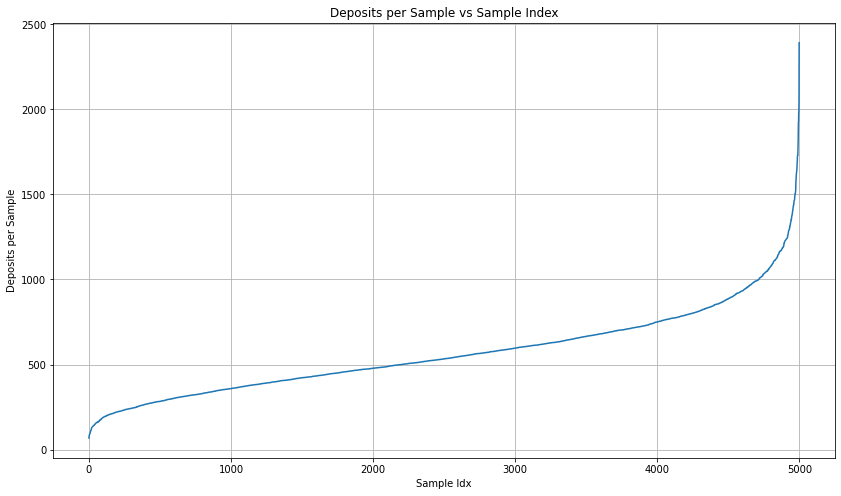

In [ ]:
plt.figure(figsize=[14,8])
plt.title('Deposits per Sample vs Sample Index')
plt.plot(sorted(samples))
plt.xlabel('Sample Idx')
plt.ylabel('Deposits per Sample')
plt.grid()
plt.show()

In [ ]:
# xs = []
# ys = []

# for i in trange(5000):
#     data = dataset.get(i)
#     out = parse_img(data[1], verbose=False)
#     xs += out[:,0]
#     ys += out[:,1]
#     # samples.append(out.shape[0])

In [ ]:
# l = len(xs)
# plt.figure(figsize=[9,9])
# plt.plot(xs[:l], ys[:l], '.', markersize=0.1)
# plt.show()

In [ ]:
# data.shape

In [ ]:
# xs = []
# ys = []
# vs = []

# for idx in range(1000):
#     data = dataset.get(idx)
#     out = parse_img(data[1], verbose=False)
#     xs.append(out[:,0])
#     ys.append(out[:,1])
#     vs.append(out[:,2])

In [ ]:
# multiplier = 10
# num_rows = 2
# num_cols = 3

# for i in range(0, 30, num_rows*num_cols):
#     fig, ax = plt.subplots(num_rows, num_cols, figsize=[16,12])

#     for ri, row in enumerate(ax):
#         for ci, col in enumerate(row):
#             index = multiplier * (i + ri*num_cols + ci)
#             # col.plot(xs[index], ys[index], '.', markersize=3)
#             col.scatter(xs[index], ys[index], c=vs[index], s=1, cmap='gist_heat', alpha=1)
#             col.set_title('Index: {}'.format(index))
#             col.grid()
#             col.set_xlim(0,125)
#             col.set_xticks(range(0,126,25))
#             col.set_ylim(0,125)
#             col.set_yticks(range(0,126,25))
#     plt.show()

# Block Neural Autoregressive Flow

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
from torch.utils.data import DataLoader, TensorDataset

import math
import os
import time
import argparse
import pprint
from functools import partial

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from tqdm import tqdm

In [23]:
def get_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--train', action='store_true', help='Train a flow.')
    parser.add_argument('--plot', action='store_false', help='Plot a flow and target density.')
    parser.add_argument('--restore_file', type=str, help='Path to model to restore.')
    parser.add_argument('--output_dir', default='./results/run_')
    parser.add_argument('--cuda', type=int, help='Which GPU to run on.')
    parser.add_argument('--seed', type=int, default=0, help='Random seed.')
    # model parameters
    parser.add_argument('--data_dim', type=int, default=2, help='Dimension of the data.')
    parser.add_argument('--hidden_dim', type=int, default=100, help='Dimensions of hidden layers.')
    parser.add_argument('--n_hidden', type=int, default=3, help='Number of hidden layers.')
    # training parameters
    parser.add_argument('--step', type=int, default=0, help='Current step of training (number of minibatches processed).')
    parser.add_argument('--n_steps', type=int, default=1, help='Number of steps to train.')
    parser.add_argument('--batch_size', type=int, default=200, help='Training batch size.')
    parser.add_argument('--lr', type=float, default=1e-1, help='Initial learning rate.')
    parser.add_argument('--lr_decay', type=float, default=0.5, help='Learning rate decay.')
    parser.add_argument('--lr_patience', type=float, default=2000, help='Number of steps before decaying learning rate.')
    parser.add_argument('--log_interval', type=int, default=50, help='How often to save model and samples.')

    args = parser.parse_args([])
    args.output_dir = os.path.join('./results/run_', time.strftime('%Y-%m-%d_%H-%M-%S', time.gmtime()))
    if not os.path.isdir(args.output_dir): 
        os.makedirs(args.output_dir)
    args.device = torch.device('cuda:{}'.format(args.cuda) if args.cuda is not None and torch.cuda.is_available() else 'cpu')

    return args

In [24]:
''' Model components ''' 

class MaskedLinear(nn.Module):
    def __init__(self, in_features, out_features, data_dim):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.data_dim = data_dim
        # print(self.in_features, self.out_features, self.data_dim)

        # Notation:
        # BNAF weight calculation for (eq 8): W = g(W) * M_d + W * M_o
        #   where W is block lower triangular so model is autoregressive,
        #         g = exp function; M_d is block diagonal mask; M_o is block off-diagonal mask.
        # Weight Normalization (Salimans & Kingma, eq 2): w = g * v / ||v||
        #   where g is scalar, v is k-dim vector, ||v|| is Euclidean norm
        # ------
        # Here: pre-weight norm matrix is v; then: v = exp(weight) * mask_d + weight * mask_o
        #       weight-norm scalar is g: out_features dimensional vector (here logg is used instead to avoid taking logs in the logdet calc.
        #       then weight-normed weight matrix is w = g * v / ||v||
        #
        #       log det jacobian of block lower triangular is taking block diagonal mask of
        #           log(g*v/||v||) = log(g) + log(v) - log(||v||)
        #                          = log(g) + weight - log(||v||) since v = exp(weight) * mask_d + weight * mask_o

        weight = torch.zeros(out_features, in_features)
        mask_d = torch.zeros_like(weight)
        mask_o = torch.zeros_like(weight)
        for i in range(data_dim):
            # select block slices
            h     = slice(i * out_features // data_dim, (i+1) * out_features // data_dim)
            w     = slice(i * in_features // data_dim,  (i+1) * in_features // data_dim)
            w_row = slice(0,                            (i+1) * in_features // data_dim)
            # initialize block-lower-triangular weight and construct block diagonal mask_d and lower triangular mask_o
            nn.init.kaiming_uniform_(weight[h,w_row], a=math.sqrt(5))  # default nn.Linear weight init only block-wise
            mask_d[h,w] = 1
            mask_o[h,w_row] = 1

        mask_o = mask_o - mask_d  # remove diagonal so mask_o is lower triangular 1-off the diagonal

        self.weight = nn.Parameter(weight)                          # pre-mask, pre-weight-norm
        self.logg = nn.Parameter(torch.rand(out_features, 1).log()) # weight-norm parameter
        self.bias = nn.Parameter(nn.init.uniform_(torch.rand(out_features), -1/math.sqrt(in_features), 1/math.sqrt(in_features)))  # default nn.Linear bias init
        self.register_buffer('mask_d', mask_d)
        self.register_buffer('mask_o', mask_o)

    def forward(self, x, sum_logdets):
        # 1. compute BNAF masked weight eq 8
        v = self.weight.exp() * self.mask_d + self.weight * self.mask_o
        # 2. weight normalization
        v_norm = v.norm(p=2, dim=1, keepdim=True)
        w = self.logg.exp() * v / v_norm
        # 3. compute output and logdet of the layer
        out = F.linear(x, w, self.bias)
        # print('Out:', out.shape)


        logdet = self.logg + self.weight - 0.5 * v_norm.pow(2).log()
        logdet = logdet[self.mask_d.byte()]
        logdet = logdet.view(1, self.data_dim, out.shape[1]//self.data_dim, x.shape[1]//self.data_dim) \
                       .expand(x.shape[0],-1,-1,-1)  # output (B, data_dim, out_dim // data_dim, in_dim // data_dim)

        # 4. sum with sum_logdets from layers before (BNAF section 3.3)
        # Compute log det jacobian of the flow (eq 9, 10, 11) using log-matrix multiplication of the different layers.
        # Specifically for two successive MaskedLinear layers A -> B with logdets A and B of shapes
        #  logdet A is (B, data_dim, outA_dim, inA_dim)
        #  logdet B is (B, data_dim, outB_dim, inB_dim) where outA_dim = inB_dim
        #
        #  Note -- in the first layer, inA_dim = in_features//data_dim = 1 since in_features == data_dim.
        #            thus logdet A is (B, data_dim, outA_dim, 1)
        #
        #  Then:
        #  logsumexp(A.transpose(2,3) + B) = logsumexp( (B, data_dim, 1, outA_dim) + (B, data_dim, outB_dim, inB_dim) , dim=-1)
        #                                  = logsumexp( (B, data_dim, 1, outA_dim) + (B, data_dim, outB_dim, outA_dim), dim=-1)
        #                                  = logsumexp( (B, data_dim, outB_dim, outA_dim), dim=-1) where dim2 of tensor1 is broadcasted
        #                                  = (B, data_dim, outB_dim, 1)

        sum_logdets = torch.logsumexp(sum_logdets.transpose(2,3) + logdet, dim=-1, keepdim=True)

        return out, sum_logdets


    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )

class Tanh(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, sum_logdets):
        # derivation of logdet:
        # d/dx tanh = 1 / cosh^2; cosh = (1 + exp(-2x)) / (2*exp(-x))
        # log d/dx tanh = - 2 * log cosh = -2 * (x - log 2 + log(1 + exp(-2x)))
        logdet = -2 * (x - math.log(2) + F.softplus(-2*x))
        sum_logdets = sum_logdets + logdet.view_as(sum_logdets)
        return x.tanh(), sum_logdets

class FlowSequential(nn.Sequential):
    """ Container for layers of a normalizing flow """
    def forward(self, x):
        sum_logdets = torch.zeros(1, x.shape[1], 1, 1, device=x.device)
        for module in self:
            x, sum_logdets = module(x, sum_logdets)
        return x, sum_logdets.squeeze()


In [25]:
''' Model '''

class BNAF(nn.Module):
    def __init__(self, data_dim, n_hidden, hidden_dim):
        super().__init__()

        # base distribution for calculation of log prob under the model
        self.register_buffer('base_dist_mean', torch.zeros(data_dim))
        self.register_buffer('base_dist_var', torch.ones(data_dim))

        # construct model
        modules = []
        modules += [MaskedLinear(data_dim, hidden_dim, data_dim), Tanh()]
        for _ in range(n_hidden):
            modules += [MaskedLinear(hidden_dim, hidden_dim, data_dim), Tanh()]
        modules += [MaskedLinear(hidden_dim, data_dim, data_dim)]
        self.net = FlowSequential(*modules)

        # TODO --   add permutation
        #           add residual gate
        #           add stack of flows

    @property
    def base_dist(self):
        return D.Normal(self.base_dist_mean, self.base_dist_var)

    def forward(self, x):
        return self.net(x)

def compute_kl_pq_loss(model, input_data):
    sample = input_data.to(model.base_dist.loc.device)
    z, logdet = model(sample)
    return - torch.sum(model.base_dist.log_prob(z) + logdet, dim=1)


In [26]:
''' Training ''' 

def train_flow(model, dataset, loss_fn, optimizer, scheduler, args):
    model.train()

    for idx in range(args.n_steps):
        args.step += 1

        input_data = dataset.__getitem__(idx)
        input_data = input_data.reshape(1,-1)
        loss = loss_fn(model, input_data).mean(0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step(loss)

        print("Step: {:03d}/{:03d} | Loss: {:14.2f}".format(args.step, args.n_steps, loss.item()))
        wandb.log({'Step': args.step, 'Loss': loss.item()})

        if args.step % args.log_interval == 0:
            # save model
            torch.save({'step': args.step,
                        'state_dict': model.state_dict()},
                        os.path.join(args.output_dir, 'checkpoint.pt'))
            torch.save({'optimizer': optimizer.state_dict(),
                        'scheduler': scheduler.state_dict()},
                        os.path.join(args.output_dir, 'optim_checkpoint.pt'))


In [27]:
DEFAULT_CFG = {
    'model': 'BNAF',
    'root_dir': ROOT,
}

In [30]:
import warnings
warnings.filterwarnings('ignore')

# Get Args
args = get_args()

# Set custom args
args.data_dim = 3072
args.hidden_dim = 6144   #3072
args.n_steps = 500
args.log_interval = 200
args.cuda = 0
args.lr = 0.3
args.step = 0

# Set Seeds
torch.manual_seed(args.seed)
if args.device.type == 'cuda': 
    torch.cuda.manual_seed(args.seed)

# Get Model
model = BNAF(args.data_dim, args.n_hidden, args.hidden_dim).to(args.device)
if args.restore_file:
    model_checkpoint = torch.load(args.restore_file, map_location=args.device)
    model.load_state_dict(model_checkpoint['state_dict'])
    args.step = model_checkpoint['step']

# Save Config
config = 'Parsed args:\n{}\n\n'.format(pprint.pformat(args.__dict__)) + \
            'Num trainable params: {:,.0f}\n\n'.format(sum(p.numel() for p in model.parameters())) + \
            'Model:\n{}'.format(model)

config_path = os.path.join(args.output_dir, 'config.txt')
if not os.path.exists(config_path):
    with open(config_path, 'a') as f:
        print(config, file=f)

# Get Optimizer + Scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=args.lr_decay, patience=args.lr_patience, verbose=True)
if args.restore_file:
    optim_checkpoint = torch.load(os.path.dirname(args.restore_file) + '/optim_checkpoint.pt', map_location=args.device)
    optimizer.load_state_dict(optim_checkpoint['optimizer'])
    scheduler.load_state_dict(optim_checkpoint['scheduler'])

# Initialize Dataset 
dataset_file = DATA_ROOT + INPUT_FORMAT.format(0)
dataset = ParquetDataset(dataset_file)

# Define Loss
loss_fn = compute_kl_pq_loss

In [ ]:
# Init Wandb
os.environ["WANDB_SILENT"] = "true"
os.environ["WANDB_NOTES"] = WANDB_DESC
run = wandb.init(project='gnf', config=DEFAULT_CFG, dir=LOGS_ROOT)
wandb.config.update(args)

# Save 
! pip freeze > requirements.txt
wandb.save(ROOT + 'requirements.txt')
# wandb.save(config_path)

In [ ]:
# Train The Model
train_flow(model, dataset, loss_fn, optimizer, scheduler, args)

Step: 001/500 | Loss:       52852.94
Step: 002/500 | Loss:     1743355.50
Step: 003/500 | Loss:     1205784.50
Step: 004/500 | Loss:      849770.25
Step: 005/500 | Loss:      766316.81
Step: 006/500 | Loss:      548363.38
Step: 007/500 | Loss:      607300.44
Step: 008/500 | Loss:      381802.88
Step: 009/500 | Loss:      354334.72
Step: 010/500 | Loss:      369371.41
Step: 011/500 | Loss:      212256.97
Step: 012/500 | Loss:      254401.91
Step: 013/500 | Loss:      182546.31
Step: 014/500 | Loss:      176235.92
Step: 015/500 | Loss:      210792.38
Step: 016/500 | Loss:      259651.66
Step: 017/500 | Loss:      144628.36
Step: 018/500 | Loss:      142434.80
Step: 019/500 | Loss:      161894.08
Step: 020/500 | Loss:      180593.16
Step: 021/500 | Loss:      201345.38
Step: 022/500 | Loss:      123744.62
Step: 023/500 | Loss:      156848.12
Step: 024/500 | Loss:      155926.66
Step: 025/500 | Loss:      125304.18
Step: 026/500 | Loss:      155676.69
Step: 027/500 | Loss:       97362.49
S

KeyboardInterrupt: ignored

Error in atexit._run_exitfuncs:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/wandb_run.py", line 1602, in _atexit_cleanup
    self._on_finish()
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/wandb_run.py", line 1767, in _on_finish
    self._poll_exit_response = self._wait_for_finish()
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/wandb_run.py", line 1715, in _wait_for_finish
    poll_exit_resp = self._backend.interface.communicate_poll_exit()
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/interface/interface.py", line 783, in communicate_poll_exit
    result = self._communicate(rec)
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/interface/interface.py", line 545, in _communicate
    return self._communicate_async(rec, local=local).get(timeout=timeout)
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/interface/interface.py", line 550, in _communicate_async
    raise Exception("The wandb backe

In [50]:
# def fill_cfg(default_cfg, args):
#     keys = [k for k in dir(args) if k[0] != '_']
#     for key in keys:
#         default_cfg[key] = args.__getattribute__(key)
#     return default_cfg

In [76]:
dir(wandb.config)

['__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_as_dict',
 '_callback',
 '_check_locked',
 '_items',
 '_load_defaults',
 '_locked',
 '_sanitize',
 '_sanitize_dict',
 '_set_callback',
 '_set_settings',
 '_settings',
 '_update',
 '_users',
 '_users_cnt',
 '_users_inv',
 'as_dict',
 'get',
 'items',
 'keys',
 'persist',
 'setdefaults',
 'update',
 'update_locked']

wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


['/content/drive/My Drive/_GSoC/Normalizing-Flows/logs/wandb/run-20210625_105407-6ydhge4q/files/requirements.txt',
 '/content/drive/My Drive/_GSoC/Normalizing-Flows/logs/wandb/run-20210625_105407-6ydhge4q/files/requirements.txt']

In [160]:
wandb.save('conf.txt')

OSError: ignored

In [162]:
! ls

cache  environment.yml	logs  README.md		results
data   get_dataset.sh	nbs   requirements.txt


In [166]:
wandb.run.dir

'/content/drive/My Drive/_GSoC/Normalizing-Flows/logs/wandb/run-20210625_105407-6ydhge4q/files'

In [173]:
ls '/content/drive/My Drive/_GSoC/Normalizing-Flows/logs/wandb/run-20210625_105407-6ydhge4q/files'

config.yaml  output.log        results/             wandb-summary.json
diff.patch   requirements.txt  wandb-metadata.json


In [168]:
cat '/content/drive/My Drive/_GSoC/Normalizing-Flows/logs/wandb/run-20210625_105407-6ydhge4q/files/config.yaml'

wandb_version: 1

_wandb:
  desc: null
  value:
    cli_version: 0.10.32
    framework: torch
    is_jupyter_run: true
    is_kaggle_kernel: false
    python_version: 3.7.10
    t:
      1:
      - 1
      4: 3.7.10
      5: 0.10.32
      8:
      - 1
      - 5
batch_size:
  desc: null
  value: 200
cuda:
  desc: null
  value: 0
data_dim:
  desc: null
  value: 3072
device:
  desc: null
  value: cpu
hidden_dim:
  desc: null
  value: 3072
log_interval:
  desc: null
  value: 200
lr:
  desc: null
  value: 0.1
lr_decay:
  desc: null
  value: 0.5
lr_patience:
  desc: null
  value: 2000
n_hidden:
  desc: null
  value: 3
n_steps:
  desc: null
  value: 500
output_dir:
  desc: null
  value: ./results/run_/2021-06-25_10-54-07
plot:
  desc: null
  value: true
restore_file:
  desc: null
  value: null
seed:
  desc: null
  value: 0
step:
  desc: null
  value: 0
train:
  desc: null
  value: false


In [152]:
! pwd

/content/drive/MyDrive/_GSoC/Normalizing-Flows


In [147]:
! ls -l '/content/drive/My Drive/_GSoC/Normalizing-Flows/logs/wandb/run-20210625_105407-6ydhge4q/'

total 141
drwx------ 3 root root   4096 Jun 25 11:36 files
drwx------ 2 root root   4096 Jun 25 10:54 logs
-rw------- 1 root root 131942 Jun 25 11:33 run-6ydhge4q.wandb
drwx------ 3 root root   4096 Jun 25 10:54 tmp


In [60]:
! tree -I 'model*|temp__*|wandb*|run_*'

.
├── cache
│   └── X_dict.pkl
├── data
│   ├── Boosted_Jets_Sample-0.snappy.parquet
│   ├── Boosted_Jets_Sample-1.snappy.parquet
│   ├── Boosted_Jets_Sample-2.snappy.parquet
│   ├── Boosted_Jets_Sample-3.snappy.parquet
│   └── Boosted_Jets_Sample-4.snappy.parquet
├── get_dataset.sh
├── logs
├── nbs
│   ├── nb1.ipynb
│   └── Starter.ipynb
├── README.md
└── results

5 directories, 10 files


# Planar Flows

In [ ]:
import torch
import torch.nn as nn
import torch.distributions as D

import math
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

import os
import argparse

In [ ]:
def get_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--train', action='store_true', help='Train a flow.')
    parser.add_argument('--evaluate', action='store_true', help='Evaluate a flow.')
    parser.add_argument('--plot', action='store_true', help='Plot a flow and target density.')
    parser.add_argument('--restore_file', type=str, help='Path to model to restore.')
    parser.add_argument('--output_dir', default='.', help='Path to output folder.')
    parser.add_argument('--no_cuda', action='store_true', help='Do not use cuda.')

    # target potential
    parser.add_argument('--target_potential', choices=['u_z0', 'u_z5', 'u_z1', 'u_z2', 'u_z3', 'u_z4'], help='Which potential function to approximate.')

    # flow params
    parser.add_argument('--base_sigma', type=float, default=4, help='Std of the base isotropic 0-mean Gaussian distribution.')
    parser.add_argument('--learn_base', default=False, action='store_true', help='Whether to learn a mu-sigma affine transform of the base distribution.')
    parser.add_argument('--flow_length', type=int, default=2, help='Length of the flow.')

    # training params
    parser.add_argument('--init_sigma', type=float, default=1, help='Initialization std for the trainable flow parameters.')
    parser.add_argument('--batch_size', type=int, default=100)
    parser.add_argument('--start_step', type=int, default=0, help='Starting step (if resuming training will be overwrite from filename).')
    parser.add_argument('--n_steps', type=int, default=1000000, help='Optimization steps.')
    parser.add_argument('--lr', type=float, default=1e-5, help='Learning rate.')
    parser.add_argument('--weight_decay', type=float, default=1e-3, help='Weight decay.')
    parser.add_argument('--beta', type=float, default=1, help='Multiplier for the target potential loss.')
    parser.add_argument('--seed', type=int, default=2, help='Random seed.')

    args = parser.parse_args([])
    args.device = torch.device('cuda:0' if torch.cuda.is_available() and not args.no_cuda else 'cpu')
    torch.manual_seed(args.seed)
    if args.device.type == 'cuda': torch.cuda.manual_seed(args.seed)
    
    return args